# Library upload

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import seaborn as sns
import pickle as pkl
import plotly.express as px
from skimage import util
from PIL import Image
from wordcloud import WordCloud
from plotly.subplots import make_subplots
from dash import Dash, dcc, html, Input, Output

import src.data.Preprocessing as pproc
import src.data.Text_preprocessing as txt_pproc

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

directory = os.getcwd()
data_path = os.path.join(directory, 'Data')

# 1. Data upload

In [2]:
breweries_path = os.path.join(data_path, 'unified_breweries_raw.pkl')
with open(breweries_path, 'rb') as f:
    df_breweries = pkl.load(f)

users_path = os.path.join(data_path, 'unified_users_raw.pkl')
with open(users_path, 'rb') as f:
    df_users = pkl.load(f)

beers_path = os.path.join(data_path, 'unified_beers_raw.pkl')
with open(beers_path, 'rb') as f:
    df_beers = pkl.load(f)

ratings_path = os.path.join(data_path, 'unified_ratings_raw.pkl')
with open(ratings_path, 'rb') as f:
    df_ratings = pkl.load(f)

# 2. Data Exploration and filtering

In [3]:
palette_styles = dict(zip(df_ratings['macro_style'].unique(), sns.color_palette('tab20', 20)[:20]))
df_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,date,rating,user_id,text,abv,...,country_user,country_brewery,macro_style,year,Trimester,z_score,exp_mean,diff_exp_mean,ith_rating,detrend
0,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2003-10-15 10:00:00,3.55,11266.0,I had this one on tap while in New Orleans. I...,8.0,...,United States,United States,Bock,2003,T4,-0.201300,-0.201300,0.000000,1,-0.048602
1,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2003-12-22 11:00:00,3.85,6816.0,Well carbonated greenish gold. The color is a...,8.0,...,United States,United States,Bock,2003,T4,0.229657,0.014178,0.215479,2,0.382151
2,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-04-06 10:00:00,2.90,5470.0,Everything about this beer seemed average or ...,8.0,...,United States,United States,Bock,2004,T2,-1.256291,-0.409311,-0.846979,3,-1.104001
3,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-04-22 10:00:00,2.39,5545.0,This can't be a dopplebock. The bar listed it...,8.0,...,United States,United States,Bock,2004,T2,-2.024569,-0.813126,-1.211444,4,-1.872485
4,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-05-02 10:00:00,3.28,32532.0,I had this on tap at the Abita Brew Pub in Ab...,8.0,...,United States,United States,Bock,2004,T2,-0.683847,-0.787270,0.103423,5,-0.531967


In [4]:
# Filter to get only users with a minimum amount of reviews
df_users_filt, df_ratings_filt_users = pproc.filter_by_value(df_users, df_ratings, 20, 'total_nbr_ratings', 'user_id')

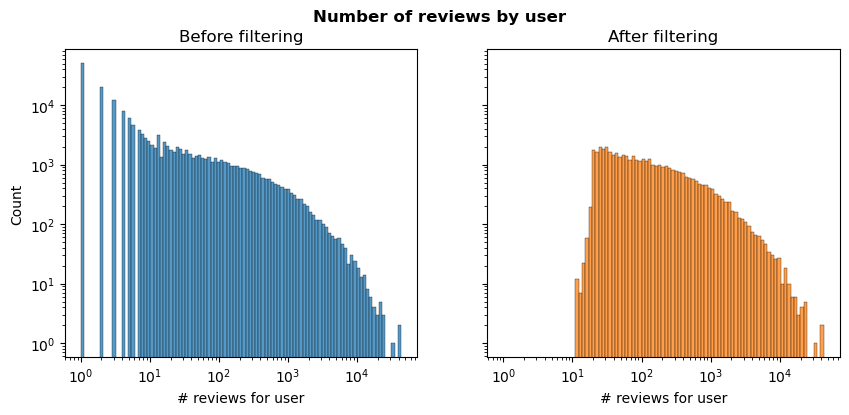

In [5]:
# Plot settings
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10,4))

# Computing the number of reviews written by each user without filtering
users_counts = df_ratings.groupby('user_id').size().reset_index().rename(columns={0: 'reviews_by_user'})
sns.histplot(data = users_counts, x='reviews_by_user', log_scale=True, ax=ax[0], color='tab:blue')
ax[0].set_title('Before filtering')
ax[0].set_xlabel('# reviews for user')

# Computing the number of reviews written by each user after filtering
users_counts_filt = df_ratings_filt_users.groupby('user_id').size().reset_index().rename(columns={0: 'reviews_by_user'})
sns.histplot(data = users_counts_filt, x='reviews_by_user', log_scale=True, ax=ax[1], color='tab:orange')
ax[1].set_title('After filtering')
ax[1].set_xlabel('# reviews for user')

# Plotting the results
fig.suptitle('Number of reviews by user', weight='bold')
plt.yscale('log')
plt.show()

In [6]:
# Calculating the number of breweries in the df_breweries without beers
print(f'There are {(df_breweries.total_nbr_beers == 0).sum()} breweries without beers')

# Dropping breweries in the df_breweries without reviwes for beers
df_breweries_filt = df_breweries[~(df_breweries['total_nbr_beers'] == 0)]

There are 1627 breweries without beers


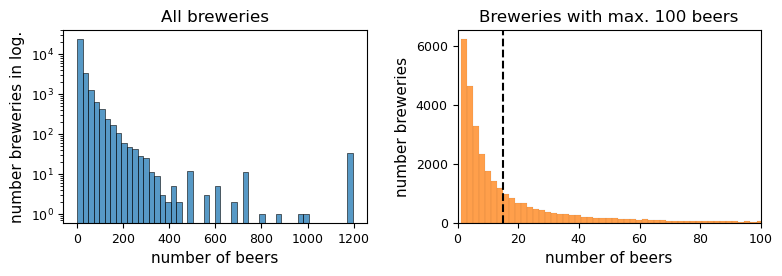

In [7]:
# Plot settings
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,2.5), sharex=False, sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.3})

# Histograms showing the complete distribution of the number of beers per brewery on the left and the number of breweries producing up to 100 beers on the right
sns.histplot(data=df_breweries_filt, x='total_nbr_beers', bins=50, ax=axs[0], color='tab:blue')
axs[0].set_xlabel('number of beers', fontsize='11')
axs[0].set_ylabel('number breweries in log.', fontsize='11')
axs[0].set_yscale('log')
axs[0].set_title('All breweries', fontsize='12')
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontsize(9)

sns.histplot(data=df_breweries_filt, x='total_nbr_beers', bins=600, ax=axs[1], color='tab:orange')
axs[1].set_xlim(0,100)
axs[1].set_xlabel('number of beers', fontsize='11')
axs[1].set_ylabel('number breweries', fontsize='11')
axs[1].set_title('Breweries with max. 100 beers', fontsize='12')
axs[1].axvline(15, color='black', ls='--')
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontsize(9)

# Showing plot
plt.show()

In [8]:
# Filter to have only location with at least 30 breweries
brewery_per_location_counts = df_breweries_filt.groupby('country_brewery').size().reset_index().rename(columns={0:'brewery_per_location'})
brewery_per_location_counts_filt, df_ratings_filt_countries = pproc.filter_by_ratings(brewery_per_location_counts, df_ratings_filt_users, 30, 'brewery_per_location', 'country_brewery')
df_breweries_filt = df_breweries_filt[df_breweries_filt['country_brewery'].isin(brewery_per_location_counts_filt['country_brewery'])]

In [9]:
# Filters countries that do not have at least minimum amount of styles per trimester
df_ratings_filt_countries_2, df_breweries_filt_2 = pproc.filter_countries(df_ratings_filt_countries, df_breweries_filt, 3)

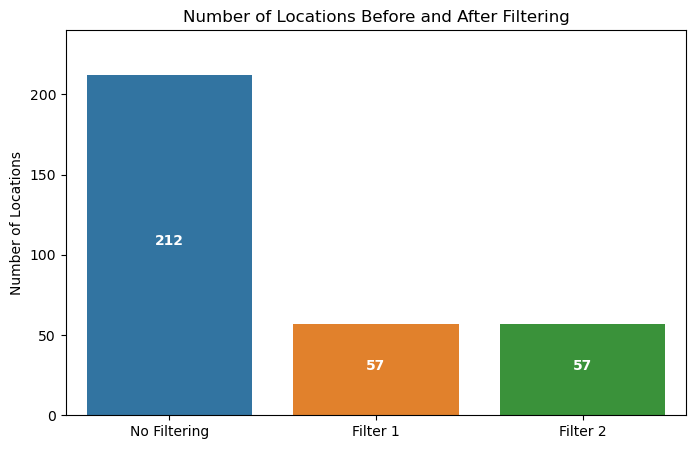

In [10]:
# Dataframe for showing reduction of countries after filtering to have a certain amount of brewery per location
# and to have a minimum amount of styles per trimester
data_filt_countries = pd.DataFrame({
    'Status': ['No Filtering', 'Filter 1', 'Filter 2'],
    'Count': [len(brewery_per_location_counts), len(brewery_per_location_counts_filt), df_breweries_filt_2['country_brewery'].nunique()]
})

# Create a point plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Status', y='Count', data=data_filt_countries, palette={'No Filtering': 'tab:blue', 'Filter 1': 'tab:orange', 'Filter 2': 'tab:green'})
plt.ylim([0,240])
plt.title('Number of Locations Before and After Filtering')
plt.xlabel('')
plt.ylabel('Number of Locations')

for i, v in enumerate(data_filt_countries['Count']):
   ax.text(i, v/2, str(v), ha='center', weight='bold', color='white')

# Showing plot
plt.show()

# 3. Data analysis

In [11]:
# Loading the filtered dataframes
dpath = './Data/unified_breweries.pkl'
with open(dpath, 'rb') as f:
    df_breweries_final_filt = pkl.load(f)

dpath = './Data/unified_users.pkl'
with open(dpath, 'rb') as f:
    df_users_final_filt = pkl.load(f)

dpath = './Data/unified_ratings.pkl'
with open(dpath, 'rb') as f:
    df_ratings_final_filt = pkl.load(f)

dpath = './Data/unified_beers.pkl'
with open(dpath, 'rb') as f:
    df_beers_final_filt = pkl.load(f)

### Locality VS industriality by country

In [12]:
# Here we define the threshold for local vs industrial breweries
# Local breweries < 15 beers produced
# Industrial breweries > 15 beers produced
df_breweries_final_filt['local_brewery'] = df_breweries_final_filt['total_nbr_beers'].apply(lambda x: True if x < 15 else False)
df_breweries_final_filt

,brewery_id,country_brewery,name,nbr_beers_rb,total_nbr_beers,nbr_beers_ba,local_brewery
1,13538.0,United Kingdom,Ards Brewing Co.,13.0,13.0,7.0,True
2,22304.0,United Kingdom,Barrahooley Craft Brewery,4.0,4.0,3.0,True
3,22818.0,United Kingdom,Boundary,66.0,66.0,0.0,False
4,24297.0,United Kingdom,Brewbot Belfast,3.0,3.0,0.0,True
5,27006.0,United Kingdom,Bullhouse Brewing Company,6.0,6.0,6.0,True
...,...,...,...,...,...,...,...
32701,40930.0,United States,White Rabbit Brewing Company,0.0,18.0,18.0,False
32704,40938.0,United States,Farmhouse Brewing Co.,0.0,4.0,4.0,True
32707,40943.0,Germany,Privatbrauerei Franz Joseph Sailer,0.0,6.0,6.0,True
32709,40945.0,United States,John Harvard’s Brewery & Ale House,0.0,491.0,491.0,False


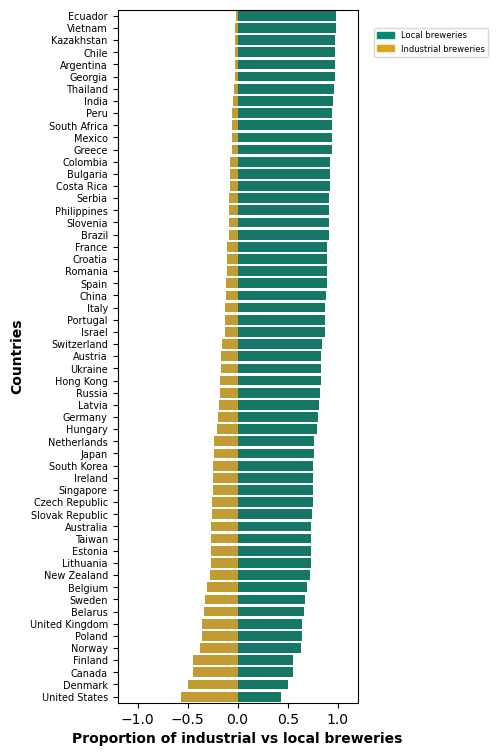

In [13]:
# Plotting the proportion of local vs industrial breweries per country
# We filtered out countries having less than 30 breweries for better statistics
fig, ax = plt.subplots(figsize=(3.1, 9))

breweries_gruped_country = df_breweries_final_filt.groupby('country_brewery').agg({'local_brewery': lambda x: x.mean()}).reset_index()
breweries_gruped_country.sort_values(by='local_brewery', ascending=False, inplace=True)
breweries_gruped_country['industrial_brewery'] = breweries_gruped_country['local_brewery'] - 1

plt.rcParams['font.size'] = '9'
for label in (ax.get_yticklabels()):
    label.set_fontsize(7)

sns.barplot(data=breweries_gruped_country, y='country_brewery', x='local_brewery', color='#058872')
sns.barplot(data=breweries_gruped_country, y='country_brewery', x='industrial_brewery', color='#DAA71A')

local_patch = mpatches.Patch(color='#058872', label='Local breweries')
industrial_patch = mpatches.Patch(color='#DAA71A', label='Industrial breweries')
plt.legend(handles=[local_patch, industrial_patch], bbox_to_anchor=(1.05, 0.98), fontsize='6', ncol=1)
plt.ylabel('Countries', weight='bold')
plt.xlabel('Proportion of industrial vs local breweries', weight='bold')
# plt.legend(labels=["Local breweries","Industrial breweries"], loc='upper left', labelcolor=['#058872', '#DAA71A'], fontsize='small')
plt.xlim(-1.2,1.2)

plt.savefig('./Data/Locality.png', dpi=400, bbox_inches='tight')
plt.show()

### Beer styles classification into macro styles

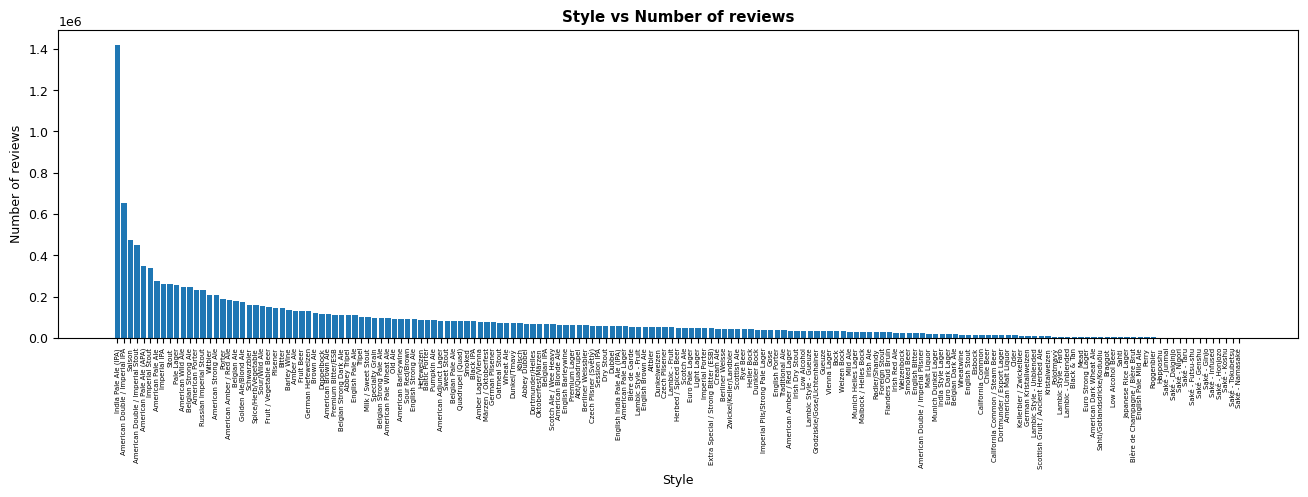

In [14]:
#Here we will see how is the distribution of the different beers
value_counts = df_ratings_final_filt['style'].value_counts()

fig, ax = plt.subplots(figsize=(16,4))
ax.bar(value_counts.index, value_counts)

# Set labels and title
ax.set_ylabel('Number of reviews')
ax.set_xlabel('Style')
ax.set_title('Style vs Number of reviews', weight='bold')
ax.tick_params(axis = 'x', labelsize = 5, rotation = 90)

# Rotate the entire plot by 90 degrees
plt.show()

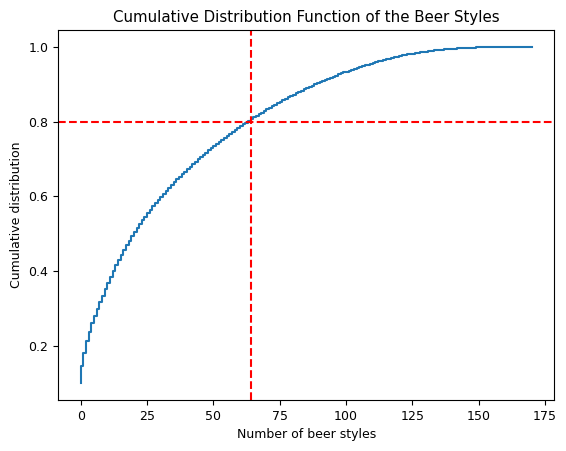

In [15]:
df_value_counts = pd.DataFrame(value_counts.values, columns = ['counts'], index = value_counts.index.values)
interval = np.arange(1, len(df_value_counts['counts'].values)+1)
cumulative_df = pd.DataFrame( df_value_counts['counts'].cumsum().values, columns= ['counts'])
cumulative_df = cumulative_df/value_counts.sum()
x_value_at_y = cumulative_df.loc[cumulative_df['counts'] >= 0.8].index[0]


plt.step(cumulative_df.index.values, cumulative_df['counts'])
plt.xlabel('Number of beer styles')
plt.ylabel('Cumulative distribution')
plt.title('Cumulative Distribution Function of the Beer Styles')


plt.axhline(y = 0.8, color = 'red', linestyle = '--')
plt.axvline(x = x_value_at_y, color = 'red', linestyle = '--')

#25 beers style represent 50% of the whole type of beers
#70 beers style represents 80% of the whole type of beers

plt.show()

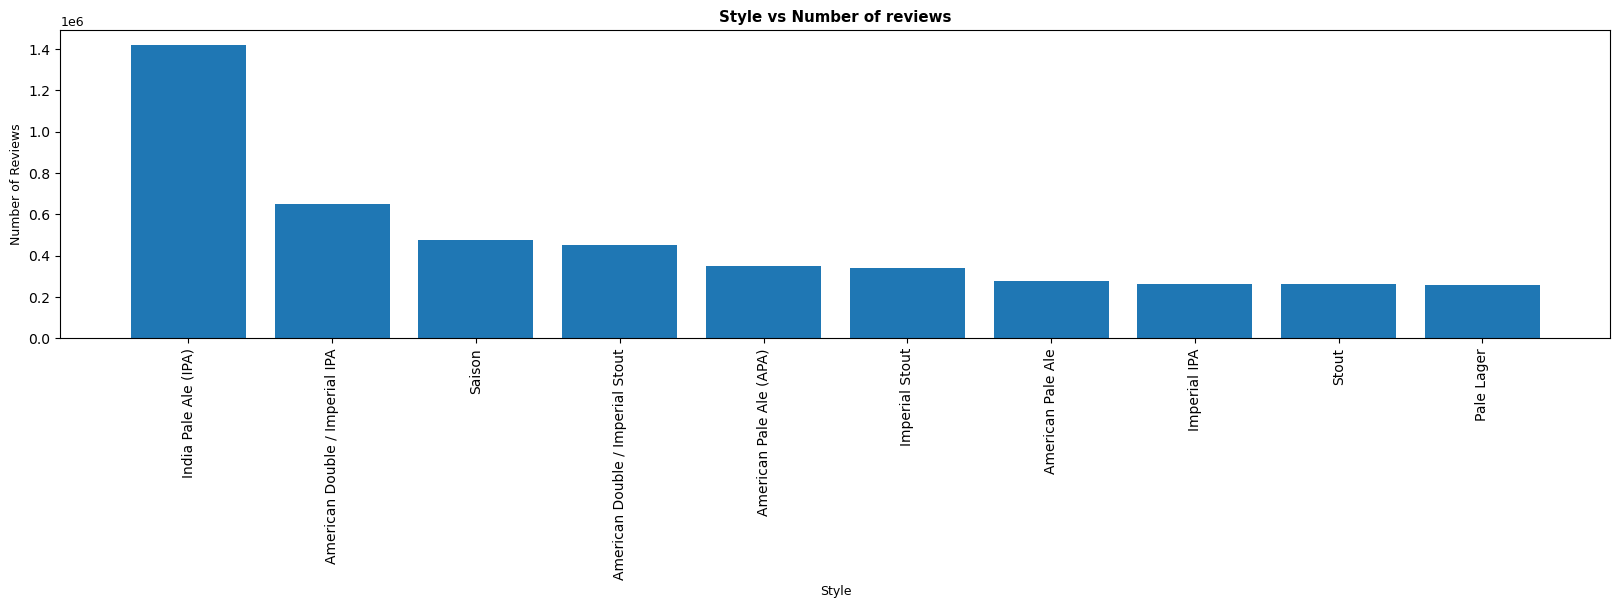

The top 10 more reviewed beer styles, represent the: 33.37% among the total 182 beer styles


In [16]:
#The top ten beer styles, how much it represents:
top_10_percentage = cumulative_df['counts'][9]

fig, ax = plt.subplots( figsize = (20,4))
ax.bar(value_counts.index[0:10], value_counts[0:10])

# Set labels and title
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('Style')
ax.set_title('Style vs Number of reviews', weight='bold')
ax.tick_params(axis = 'x', labelsize = 10, rotation=90)
ax.tick_params(axis = 'y', labelsize = 10)

# Rotate the entire plot by 90 degrees
plt.show()
print(f"The top 10 more reviewed beer styles, represent the: {top_10_percentage:.2%} among the total 182 beer styles")

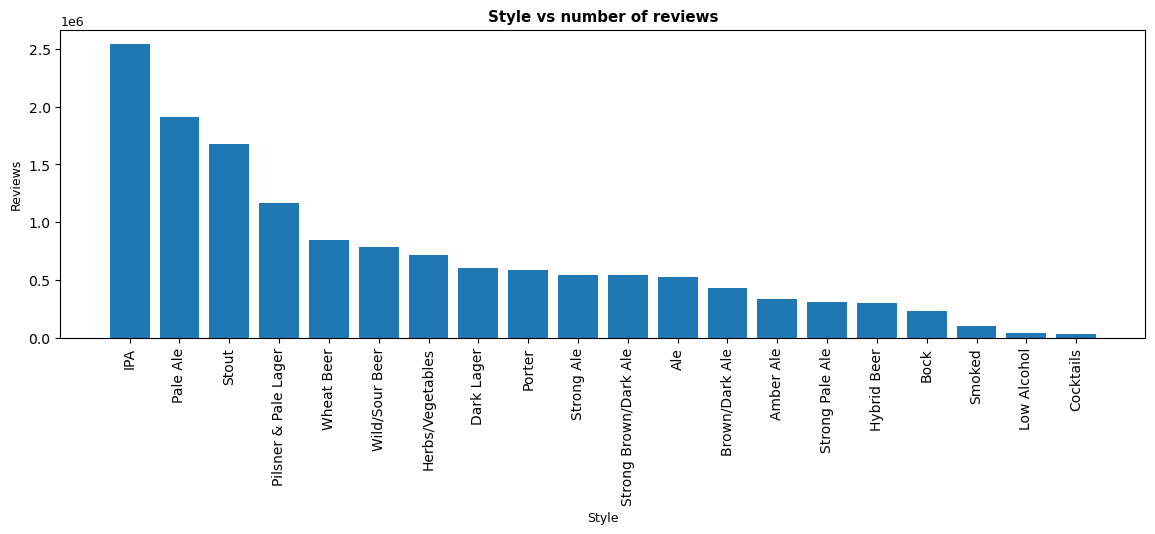

In [17]:
grouping_values = df_ratings_final_filt['macro_style'].value_counts()

fig, ax = plt.subplots( figsize = (14,4))
ax.bar(grouping_values.index, grouping_values)

# Set labels and title
ax.set_ylabel('Reviews')
ax.set_xlabel('Style')
ax.set_title('Style vs number of reviews', weight='bold')
ax.tick_params(axis = 'x', labelsize = 10, rotation = 90)
ax.tick_params(axis = 'y', labelsize = 10)

# Rotate the entire plot by 90 degrees
plt.show()

In [18]:
# Grouping the ratings dataframe by macro_style and style to get the number of reviews in each subgroup
style_grouping = df_ratings_final_filt.groupby(['macro_style', 'style']).size().reset_index().rename(columns={0:'counts'})
# Building the dataframe for the reviews distributions of the styles in each macro_style
pie_chart_styles = pd.crosstab(style_grouping['style'], style_grouping['macro_style'], values = style_grouping['counts'], aggfunc='mean')

In [19]:
#Pie chart of the distribution of styles per macro style
def macro_style_pichart(macro_style):
    fig = px.pie(pie_chart_styles, values=macro_style, names= pie_chart_styles.index.values, hole=.3)
    fig.update_layout( title_text= f"Distribution of beer styles in {macro_style} macro style")
    return fig

#We show one example among the whole macro beer styles. For the whole interactive plot go and visit the website
macro_style_pichart('Ale').show()

## Expertise analysis

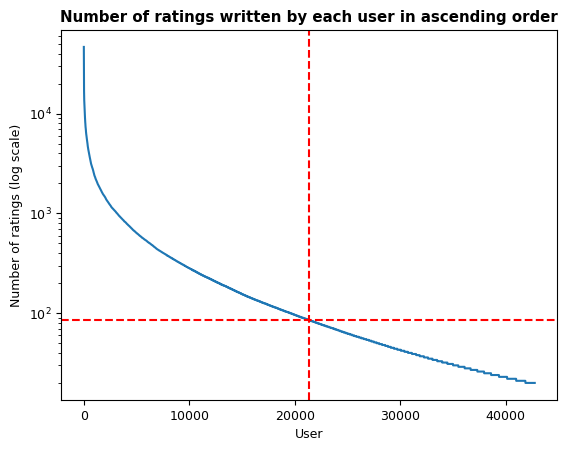

In [20]:
#We sort the values descending in log scale, where the first value has the highest number of ratings 
#And the last ones have one review
ordered_users = pd.DataFrame(df_users_final_filt.total_nbr_ratings.sort_values(ascending = False).values, columns= ['counts'])
cumulative_df = pd.DataFrame(ordered_users.cumsum().values, columns=['counts'])
cumulative_df = cumulative_df/ordered_users['counts'].sum()

#Number of users and the median value
interval = np.arange(0, len(ordered_users), 1)
median_value = ordered_users['counts'].median()
median_position = int(len(ordered_users['counts'])/2)

# Plotting the log number of ratings per user distribution
plt.plot(interval, ordered_users['counts'])
plt.yscale('log')
plt.axhline(y = median_value, color = 'red', linestyle = '--')
plt.axvline(x = median_position, color = 'red', linestyle = '--')
plt.xlabel('User')
plt.ylabel('Number of ratings (log scale)')
plt.title('Number of ratings written by each user in ascending order', weight='bold')

plt.show()

Where we can see that the distribution is very skewed: 
- Low number of users had given high number of ratings
- The majority of the users, writes low reviews

The 21.28% of users represents the 80% of the reviews. This means that each of them has done at least more than 319.0 reviews.


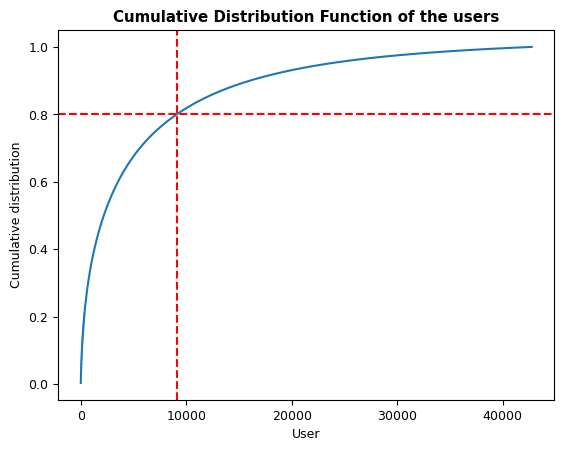

In [21]:
# Case for representing the 80% of the total reviews
x_value = cumulative_df.loc[cumulative_df['counts'] >= 0.8].index[0]

# Plotting the cumulative distributions of reviews written by users
plt.step(cumulative_df.index.values, cumulative_df['counts'])
plt.xlabel('User')
plt.ylabel('Cumulative distribution')
plt.title('Cumulative Distribution Function of the users', weight='bold')

plt.axhline(y = 0.8, color = 'red', linestyle = '--')
plt.axvline(x = x_value, color = 'red', linestyle = '--')

N = len(ordered_users['counts'])
print(f'The {x_value / N :.2%} of users represents the 80% of the reviews. This means that each of them has done at least more than {ordered_users.loc[x_value, "counts"]} reviews.')

We can see that among the total reviews, 80% is written by 5% of the users, which gave more than 319 reviews in total. 
Considering that consistent data is from 2000, during around 20 years, experts gave at least 1 review per month. Which even if this number is relatevely high, we hypothesize that experts may write more reviews.

Therefore we find what should be the ideal threshold for being able to separate the population between experts and non-experts.
This by minimizing the t-test value.


In [22]:
percentage_experts = len(ordered_users[ordered_users['counts'] >= 3352].values)/ N

print(f'The percentage of experts among the users is: {percentage_experts:.2%}')

The percentage of experts among the users is: 1.49%


In [23]:
# Adding the expertise column based on the previous discussion
df_users_final_filt['expertise'] = (df_users_final_filt['total_nbr_ratings'] >= 3352).astype(int)

# Adding the expertise column to the ratings dataframe based on the users dataframe
equivalent_expertise = dict(zip(df_users_final_filt['user_id'], df_users_final_filt['expertise']))
df_ratings_final_filt['expertise']=df_ratings_final_filt['user_id'].map(equivalent_expertise)

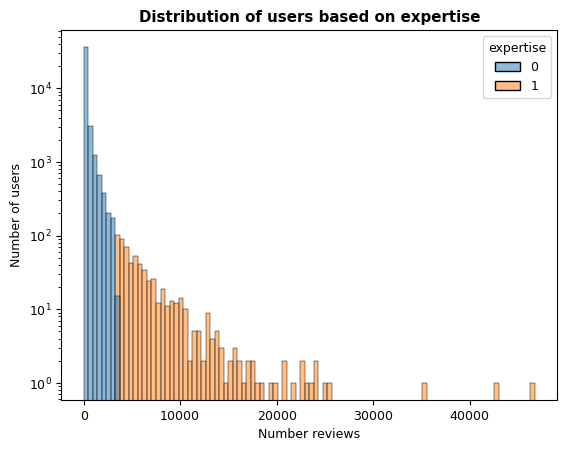

In [24]:
sns.histplot(data = df_users_final_filt, x= 'total_nbr_ratings', hue = 'expertise', log_scale= (False, True), bins = 100)
plt.xlabel('Number reviews')
plt.ylabel('Number of users')
plt.title('Distribution of users based on expertise', weight='bold')

plt.show()

### Top 4 most popular beer styles per country and per trimester

In [25]:
top_4_beerstyles = df_ratings_final_filt[['macro_style', 'Trimester', 'country_brewery']]
top_4_beerstyles = top_4_beerstyles.groupby(['country_brewery', 'Trimester'])['macro_style'].value_counts().groupby(['country_brewery', 'Trimester']).head(4).reset_index(name='counts')

In [26]:
T1_top4 = top_4_beerstyles[top_4_beerstyles['Trimester'] == 'T1']
T2_top4 = top_4_beerstyles[top_4_beerstyles['Trimester'] == 'T2']
T3_top4 = top_4_beerstyles[top_4_beerstyles['Trimester'] == 'T3']
T4_top4 = top_4_beerstyles[top_4_beerstyles['Trimester'] == 'T4']

In [27]:
#We create the dataframes for the 4 different trimesters
T1_reviews = pd.crosstab(T1_top4['country_brewery'], T1_top4['macro_style'], 
                             values = T1_top4['counts'], aggfunc= 'mean')
T2_reviews = pd.crosstab(T2_top4['country_brewery'], T2_top4['macro_style'], 
                             values = T2_top4['counts'], aggfunc= 'mean')
T3_reviews = pd.crosstab(T3_top4['country_brewery'], T3_top4['macro_style'], 
                             values = T3_top4['counts'], aggfunc= 'mean')
T4_reviews = pd.crosstab(T4_top4['country_brewery'], T4_top4['macro_style'], 
                             values = T4_top4['counts'], aggfunc= 'mean')

In [28]:
#Pie chart plot showing the distribution of the top 4 most reviewed beer styles in a country per trimester

def trimester_country_piechart(names):
        fig = make_subplots(rows=2, cols=2, subplot_titles= ['January-March', 'April-June', 'July-September', 'October-December'],
                             specs=[[{'type': 'domain'}, {'type': 'domain'}], [{'type': 'domain'}, {'type': 'domain'}]])

        T1_pie = px.pie(T1_reviews.T, values= names, names=T1_reviews.T.index.values, hole=0.3)
        fig.add_trace(T1_pie['data'][0], 1, 1)

        # Add pie chart for winter_reviews
        T2_pie = px.pie(T2_reviews.T, values= names, names=T2_reviews.T.index.values, hole=0.3)
        fig.add_trace(T2_pie['data'][0], 1, 2)

        # Add pie chart for summer_reviews
        T3_pie = px.pie(T3_reviews.T, values= names, names=T3_reviews.T.index.values, hole=0.3)
        fig.add_trace(T3_pie['data'][0], 2, 1)

        T4_pie = px.pie(T4_reviews.T, values= names, names=T4_reviews.T.index.values, hole=0.3)
        fig.add_trace(T4_pie['data'][0], 2, 2)

        # Update layout if needed
        fig.update_layout(
                title_text= f"Top4 most reviewed beers distribution in {names} per season")
        
        #Add annotations in the center of the donut pies.
        fig.update_traces(textposition = 'inside')
        return fig

#We show one example among the country filtered list. For the whole interactive plot go and visit the website
trimester_country_piechart('Switzerland').show()

### Prefered beer styles by country

In [29]:
def weighted_average(group):
    '''
    Calculate the weighted score of the beers based on the expertise of the users and the
    score given by them
    '''
    # Define weights based on 'expertise'
    weights = {1: 1.5, 0: 1}

    # Calculate the weighted average
    weighted_avg = (group['detrend'] * group['expertise'].map(weights)).sum() / group['expertise'].map(weights).sum()

    return pd.Series({'macro_style': group['macro_style'].iloc[0], 'country_brewery': group['country_brewery'].iloc[0], 'final_score': weighted_avg})

weighted_scores = df_ratings_final_filt.groupby(['country_brewery', 'Trimester', 'macro_style'], as_index=False).apply(weighted_average)
weighted_scores = weighted_scores.sort_values(by=['country_brewery', 'Trimester', 'final_score'], ascending=[True, True, False])
desired_order = ['country_brewery', 'Trimester', 'macro_style', 'final_score']
weighted_scores = weighted_scores[desired_order]

In [30]:
top_3_beerstyles = weighted_scores.groupby(['country_brewery', 'Trimester']).head(3)

styles_combined = top_3_beerstyles.groupby(['country_brewery', 'Trimester'], as_index=False).agg(lambda x: x.tolist())

styles_combined[['1st_Style', '2nd_Style', '3rd_Style']] = pd.DataFrame(styles_combined['macro_style'].tolist(), index=styles_combined.index)
styles_combined[['1st_Score', '2nd_Score', '3rd_Score']] = pd.DataFrame(styles_combined['final_score'].tolist(), index=styles_combined.index)
styles_combined = styles_combined.drop(['macro_style', 'final_score'], axis=1)

In [31]:
countries_top=pd.crosstab(styles_combined['country_brewery'], styles_combined['Trimester'], 
                             values = styles_combined['1st_Style'], aggfunc= 'first')
countries_top=countries_top.reset_index()

In [32]:
# We use the iso_alpha3 labels for identifying the countries. This is required for the world map plot
# iso_alpha dataset was downloaded and adpated from https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
iso_alpha=pd.read_csv('./src/iso_alpha_countries.csv')
iso_alpha=iso_alpha[['name', 'alpha-3']].rename(columns = {'name':'country_brewery', 'alpha-3':'iso_alpha'})

merged = countries_top.merge(iso_alpha, on='country_brewery')

In [33]:
# Convert RGB tuples to rgb() format
beer_style_color_map_rgb = {key: f'rgb({int(r * 255)},{int(g * 255)},{int(b * 255)})'
                            for key, (r, g, b) in palette_styles.items()}

In [34]:
#Interactive plot of the preferred macro beer styles per country per season

def display_choropleth(trimester):
    df = merged # replace with your own data source
    
    fig = px.choropleth(df, locations="iso_alpha", 
                    color=trimester, #columns of merged
                    hover_name="country_brewery", # column to add to hover information
                    color_discrete_map= beer_style_color_map_rgb) 
    
    fig.update_layout( title_text= f" Preferred macro beer style per country in the trimester {trimester} macro style")

    return fig

##We show one example among the 4 trimesters. For the whole interactive plot go and visit the website
#T1 = Jan-March, T2 = Apr-Jun, T3 = Jul-Sep, T4= Oct-Dec
display_choropleth('T1').show()

## Text analysis associated to the beer styles

The rationale behind this section is to process the textual reviews given by the users in order to provide insight about the beer styles description. 

We will start by selecting only english reviews (reasons are described in the cells below) and pre-processing the reviews by using a python script. The pre-processing clears out the stopwords, punctuation, and also performs lemmatization in order to normalize the text. The next steps include the calculation of length and TF-IDF scores for each review. With this step, we can get the top 3 most representitive words for each review and then group them by the beer macro_style. By exploiting WordCloud representation we are then able to represent the most representitive words used by the users to describe the beer_styles.

\begin{equation*}
 \text{TF}(t, d) = \frac{count(t)}{count(g)} \qquad\qquad \text{IDF}(t) = \log{\frac{1+n}{1+df(t)}} + 1
\end{equation*}


\begin{equation*}
 \text{TF-IDF}(t,d) = \text{TF}(t, d) * \text{IDF}(t)
\end{equation*}

where:
- $t$ is the specific term in a document
- $g$ is the general token in a specific document
- $n$ is the total number of documents in the set
- $df(t)$ is the number of document term $t$ is present in


In [35]:
df_ratings_final_filt.head()

,beer_name,beer_id,brewery_name,brewery_id,style,date,rating,user_id,text,abv,...,country_brewery,macro_style,year,Trimester,z_score,exp_mean,diff_exp_mean,ith_rating,detrend,expertise
0,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2003-10-15 10:00:00,3.55,11266.0,I had this one on tap while in New Orleans. I...,8.0,...,United States,Bock,2003,T4,-0.201300,-0.201300,0.000000,1,-0.048602,0
1,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2003-12-22 11:00:00,3.85,6816.0,Well carbonated greenish gold. The color is a...,8.0,...,United States,Bock,2003,T4,0.229657,0.014178,0.215479,2,0.382151,0
2,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-04-06 10:00:00,2.90,5470.0,Everything about this beer seemed average or ...,8.0,...,United States,Bock,2004,T2,-1.256291,-0.409311,-0.846979,3,-1.104001,0
3,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-04-22 10:00:00,2.39,5545.0,This can't be a dopplebock. The bar listed it...,8.0,...,United States,Bock,2004,T2,-2.024569,-0.813126,-1.211444,4,-1.872485,0
4,Abita Andygator,3.0,Abita Brewing Company,1.0,Maibock / Helles Bock,2004-05-02 10:00:00,3.28,32532.0,I had this on tap at the Abita Brew Pub in Ab...,8.0,...,United States,Bock,2004,T2,-0.683847,-0.787270,0.103423,5,-0.531967,0


In [36]:
# Subsetting the txt dataframe to keep only few columns
df_txt_analysis = df_ratings_final_filt[['beer_name', 'brewery_name', 'style', 'year', 'rating', 'user_id', 'detrend', 'text']]
df_txt_analysis.dropna(subset='text', inplace=True)
df_txt_analysis.head()

,beer_name,brewery_name,style,year,rating,user_id,detrend,text
0,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2003,3.55,11266.0,-0.048602,I had this one on tap while in New Orleans. I...
1,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2003,3.85,6816.0,0.382151,Well carbonated greenish gold. The color is a...
2,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2004,2.90,5470.0,-1.104001,Everything about this beer seemed average or ...
3,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2004,2.39,5545.0,-1.872485,This can't be a dopplebock. The bar listed it...
4,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2004,3.28,32532.0,-0.531967,I had this on tap at the Abita Brew Pub in Ab...


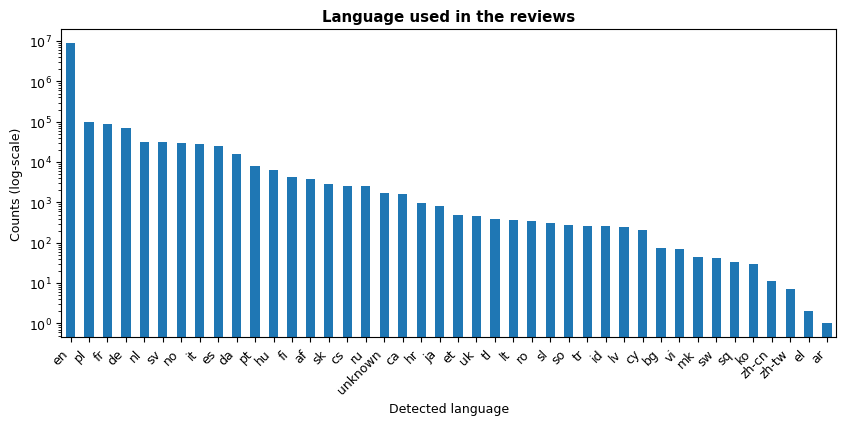

In [37]:
# Assigning language to the text analysis dataset 
df_txt_analysis = txt_pproc.adding_language('df_txt_analysis', data_path)

# Plotting the language distributions for the text analysis dataset
fig, ax = plt.subplots(figsize=(10,4))

# Plotting the language counts
language_counts = df_txt_analysis['language'].value_counts()
language_counts.plot(kind='bar')
plt.title('Language used in the reviews', weight='bold')
plt.xlabel('Detected language')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts (log-scale)')
plt.yscale('log')

plt.show()

Considering the distributions of languages detected we will filter the dataset only based on the English reviews. The reason of this choice comes from the need to find tune the parameters for each language during text pre-processing. Since English is the most common language among the reviews with 2 higher order of magnitude int counts we will only use English in the analysis.

In [38]:
# Keeping only english reviews
df_txt_analysis_en = df_txt_analysis[df_txt_analysis.language == 'en']
df_txt_analysis_en.head()

,beer_name,brewery_name,style,year,rating,user_id,detrend,text,language
0,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2003,3.55,11266.0,-0.048602,I had this one on tap while in New Orleans. I...,en
1,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2003,3.85,6816.0,0.382151,Well carbonated greenish gold. The color is a...,en
2,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2004,2.90,5470.0,-1.104001,Everything about this beer seemed average or ...,en
3,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2004,2.39,5545.0,-1.872485,This can't be a dopplebock. The bar listed it...,en
4,Abita Andygator,Abita Brewing Company,Maibock / Helles Bock,2004,3.28,32532.0,-0.531967,I had this on tap at the Abita Brew Pub in Ab...,en


In [39]:
# Text preprocessing and dropping nan values that can arise from the processing
df_txt_processed = txt_pproc.cleaning(df_txt_analysis_en, data_path)
df_txt_processed.dropna(inplace=True)
df_txt_processed.head()

,abv,beer_name,brewery_name,style,year,rating,user_name,detrend,text,language,tokenize_text
0,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2000,3.5,DJH-Bird99,0.078186,good beer espacially put dj aligator whistle song,en,"['good', 'beer', 'espacially', 'put', 'dj', 'a..."
1,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.6,pauliefrog99,-0.668204,little bit caramel malt flavor way thin weak,en,"['little', 'bit', 'caramel', 'malt', 'flavor',..."
2,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.2,daviddeep99,-1.086552,think beer make thin one part anchor foghorn t...,en,"['think', 'beer', 'make', 'thin', 'one', 'part..."
3,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.8,wodom1,-0.458480,beer actually get hammer good beer look...,en,"['beer', 'actually', 'get', 'hammer', 'good', ..."
4,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,3.0,JohnDo2000,-0.248976,beer good sure knock ass tell bartender eight ...,en,"['beer', 'good', 'sure', 'knock', 'ass', 'tell..."


In [40]:
# Adding length of each review to the dataset
df_txt_processed['len'] = df_txt_processed['tokenize_text'].apply(lambda text: len(text))
df_txt_processed.head()

,abv,beer_name,brewery_name,style,year,rating,user_name,detrend,text,language,tokenize_text,len
0,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2000,3.5,DJH-Bird99,0.078186,good beer espacially put dj aligator whistle song,en,"['good', 'beer', 'espacially', 'put', 'dj', 'a...",74
1,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.6,pauliefrog99,-0.668204,little bit caramel malt flavor way thin weak,en,"['little', 'bit', 'caramel', 'malt', 'flavor',...",69
2,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.2,daviddeep99,-1.086552,think beer make thin one part anchor foghorn t...,en,"['think', 'beer', 'make', 'thin', 'one', 'part...",155
3,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.8,wodom1,-0.458480,beer actually get hammer good beer look...,en,"['beer', 'actually', 'get', 'hammer', 'good', ...",272
4,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,3.0,JohnDo2000,-0.248976,beer good sure knock ass tell bartender eight ...,en,"['beer', 'good', 'sure', 'knock', 'ass', 'tell...",369


In [41]:
# Dictionary to map style into macro_style
beer_dict = {
    'American Pale Ale': 'Pale Ale',
    'American Blonde Ale': 'Pale Ale',
    'Golden Ale/Blond Ale': 'Pale Ale',
    'Bitter': 'Pale Ale',
    'Pale Ale': 'Pale Ale',
    'American Pale Ale (APA)': 'Pale Ale',
    'English Pale Ale': 'Pale Ale',
    'English Bitter': 'Pale Ale',
    'Premium Bitter/ESB': 'Pale Ale',
    'English India Pale Ale (IPA)': 'Pale Ale',
    'Extra Special / Strong Bitter (ESB)': 'Pale Ale',
    'Saison / Farmhouse Ale': 'Pale Ale',
    'English Pale Mild Ale': 'Pale Ale',
    'Saison': 'Pale Ale',
    'Belgian Pale Ale': 'Pale Ale',
    'Belgian Strong Pale Ale': 'Strong Pale Ale',
    'Tripel': 'Strong Pale Ale',
    'Abbey Tripel': 'Strong Pale Ale',
    'American IPA': 'IPA',
    'Black IPA': 'IPA',
    'India Pale Ale (IPA)': 'IPA',
    'American Double / Imperial IPA': 'IPA',
    'Imperial IPA': 'IPA',
    'New England IPA (NEIPA)': 'IPA',
    'Session IPA': 'IPA',
    'Belgian IPA': 'IPA',
    'Abbey Dubbel': 'Brown/Dark Ale',
    'Dubbel': 'Brown/Dark Ale',
    'Belgian Dark Ale': 'Brown/Dark Ale',
    'American Brown Ale': 'Brown/Dark Ale',
    'Brown Ale': 'Brown/Dark Ale',
    'English Dark Mild Ale': 'Brown/Dark Ale',
    'American Black Ale': 'Brown/Dark Ale',
    'English Brown Ale': 'Brown/Dark Ale',
    'Belgian Strong Dark Ale': 'Strong Brown/Dark Ale',
    'Abt/Quadrupel': 'Strong Brown/Dark Ale',
    'Barley Wine': 'Strong Brown/Dark Ale',
    'English Barleywine': 'Strong Brown/Dark Ale',
    'American Barleywine': 'Strong Brown/Dark Ale',
    'Quadrupel (Quad)': 'Strong Brown/Dark Ale',
    'Amber Ale': 'Amber Ale',
    'American Amber Ale': 'Amber Ale',
    'Irish Red Ale': 'Amber Ale',
    'American Amber / Red Ale': 'Amber Ale',
    'Red Ale': 'Amber Ale',
    'Belgian Ale': 'Ale',
    'Irish Ale': 'Ale',
    'Old Ale': 'Ale',
    'Mild Ale': 'Ale',
    'Traditional Ale': 'Ale',
    'Scotch Ale / Wee Heavy': 'Ale',
    'Scotch Ale': 'Ale',
    'Scottish Ale': 'Ale',
    'Belgian Strong Ale': 'Strong Ale',
    'American Strong Ale': 'Strong Ale',
    'English Strong Ale': 'Strong Ale',
    'Winter Warmer': 'Strong Ale',
    'Stout': 'Stout',
    'American Stout': 'Stout',
    'Dry Stout': 'Stout',
    'American Double / Imperial Stout': 'Stout',
    'English Stout': 'Stout',
    'Imperial Stout': 'Stout',
    'Irish Dry Stout': 'Stout',
    'Foreign / Export Stout': 'Stout',
    'Oatmeal Stout': 'Stout',
    'Russian Imperial Stout': 'Stout',
    'Milk / Sweet Stout': 'Stout',
    'Foreign Stout': 'Stout',
    'Sweet Stout': 'Stout',
    'Porter': 'Porter',
    'American Porter': 'Porter',
    'Baltic Porter': 'Porter',
    'Imperial Porter': 'Porter',
    'English Porter': 'Porter',
    'American Dark Wheat Ale': 'Wheat Beer',
    'Berliner Weissbier': 'Wheat Beer',
    'Dunkelweizen': 'Wheat Beer',
    'German Hefeweizen': 'Wheat Beer',
    'Hefeweizen': 'Wheat Beer',
    'Wheat Ale': 'Wheat Beer',
    'Weizen Bock': 'Wheat Beer',
    'Roggenbier': 'Wheat Beer',
    'Weizenbock': 'Wheat Beer',
    'Witbier': 'Wheat Beer',
    'German Kristallweizen': 'Wheat Beer',
    'Berliner Weisse': 'Wheat Beer',
    'Kristalweizen': 'Wheat Beer',
    'Wheatwine': 'Wheat Beer',
    'Dunkelweizen': 'Wheat Beer',
    'American Pale Wheat Ale': 'Wheat Beer',
    'Flanders Oud Bruin': 'Wild/Sour Beer',
    'Flanders Red Ale': 'Wild/Sour Beer',
    'Gose': 'Wild/Sour Beer',
    'Lambic - Fruit': 'Wild/Sour Beer',
    'American Wild Ale': 'Wild/Sour Beer',
    'Lambic - Unblended': 'Wild/Sour Beer',
    'Lambic Style - Faro': 'Wild/Sour Beer',
    'Lambic Style - Fruit': 'Wild/Sour Beer',
    'Lambic Style - Gueuze': 'Wild/Sour Beer',
    'Lambic Style - Unblended': 'Wild/Sour Beer',
    'Sour Red/Brown': 'Wild/Sour Beer',
    'Sour/Wild Ale': 'Wild/Sour Beer',
    'Faro': 'Wild/Sour Beer',
    'Gueuze': 'Wild/Sour Beer',
    'Grodziskie/Gose/Lichtenhainer': 'Wild/Sour Beer',
    'American Adjunct Lager': 'Pilsner & Pale Lager',
    'American Pale Lager': 'Pilsner & Pale Lager',
    'Pilsener': 'Pilsner & Pale Lager',
    'Dortmunder / Export Lager': 'Pilsner & Pale Lager',
    'European Pale Lager': 'Pilsner & Pale Lager',
    'German Pilsener': 'Pilsner & Pale Lager',
    'Pale Lager': 'Pilsner & Pale Lager',
    'Munich Helles Lager': 'Pilsner & Pale Lager',
    'Pilsener (German and Czech)': 'Pilsner & Pale Lager',
    'Czech Pilsener': 'Pilsner & Pale Lager',
    'Czech Pilsner (Světlý)': 'Pilsner & Pale Lager',
    'India Style Lager': 'Pilsner & Pale Lager',
    'Imperial Pils/Strong Pale Lager': 'Pilsner & Pale Lager',
    'Kellerbier / Zwickelbier': 'Pilsner & Pale Lager',
    'Euro Pale Lager': 'Pilsner & Pale Lager',
    'Zwickel/Keller/Landbier': 'Pilsner & Pale Lager',
    'Euro Strong Lager': 'Pilsner & Pale Lager',
    'American Double / Imperial Pilsner': 'Pilsner & Pale Lager',
    'Light Lager': 'Pilsner & Pale Lager',
    'Radler/Shandy': 'Pilsner & Pale Lager',
    'Japanese Rice Lager': 'Pilsner & Pale Lager',
    'Premium Lager': 'Pilsner & Pale Lager',
    'Dortmunder/Helles': 'Pilsner & Pale Lager',
    'Doppelbock': 'Bock',
    'Eisbock': 'Bock',
    'Heller Bock': 'Bock',
    'Maibock / Helles Bock': 'Bock',
    'Bock': 'Bock',
    'Amber Lager/Vienna': 'Dark Lager',
    'Munich Dunkel Lager': 'Dark Lager',
    'Schwarzbier': 'Dark Lager',
    'Vienna Lager': 'Dark Lager',
    'American Amber / Red Lager': 'Dark Lager',
    'Dunkel/Tmavý': 'Dark Lager',
    'Dunkler Bock': 'Dark Lager',
    'Euro Dark Lager': 'Dark Lager',
    'Schwarzbier': 'Dark Lager',
    'Polotmavý': 'Dark Lager',
    'Märzen / Oktoberfest': 'Dark Lager',
    'Oktoberfest/Märzen': 'Dark Lager',
    'Rauchbier': 'Smoked',
    'Smoked': 'Smoked',
    'Smoked Beer': 'Smoked',
    'Cream Ale': 'Hybrid Beer',
    'Kölsch': 'Hybrid Beer',
    'California Common': 'Hybrid Beer',
    'California Common / Steam Beer': 'Hybrid Beer',
    'Braggot': 'Hybrid Beer',
    'Bière de Garde': 'Hybrid Beer',
    'Black & Tan': 'Hybrid Beer',
    'Altbier': 'Hybrid Beer',
    'Rye Beer': 'Hybrid Beer',
    'Chile Beer': 'Herbs/Vegetables',
    'Cider': 'Herbs/Vegetables',
    'Fruit / Vegetable Beer': 'Herbs/Vegetables',
    'Fruit Beer': 'Herbs/Vegetables',
    'Herbed / Spiced Beer': 'Herbs/Vegetables',
    'Mead': 'Herbs/Vegetables',
    'Spice/Herb/Vegetable': 'Herbs/Vegetables',
    'Specialty Grain': 'Herbs/Vegetables',
    'Sahti': 'Herbs/Vegetables',
    'Sahti/Gotlandsdricke/Koduõlu': 'Herbs/Vegetables',
    'Scottish Gruit / Ancient Herbed Ale': 'Herbs/Vegetables',
    'Pumpkin Ale': 'Herbs/Vegetables',
    'Perry': 'Herbs/Vegetables',
    'Happoshu': 'Low Alcohol',
    'Low Alcohol': 'Low Alcohol',
    'Low Alcohol Beer': 'Low Alcohol',
    'Kvass': 'Low Alcohol',
    'American Malt Liquor': 'Cocktails',
    'Bière de Champagne / Bière Brut': 'Cocktails',
    'Malt Liquor': 'Cocktails',
    'Saké - Daiginjo': 'Cocktails',
    'Saké - Futsu-shu': 'Cocktails',
    'Saké - Genshu': 'Cocktails',
    'Saké - Ginjo': 'Cocktails',
    'Saké - Honjozo': 'Cocktails',
    'Saké - Infused': 'Cocktails',
    'Saké - Junmai': 'Cocktails',
    'Saké - Koshu': 'Cocktails',
    'Saké - Namasaké': 'Cocktails',
    'Saké - Nigori': 'Cocktails',
    'Saké - Taru': 'Cocktails',
    'Saké - Tokubetsu': 'Cocktails'
}
# Extracting keywords from the reviews
df_txt_keywords = txt_pproc.adding_keywords(df_txt_processed, data_path)
# Mapping styles into macro_styles
df_txt_keywords['macro_style'] = df_txt_keywords['style'].str.strip().map(beer_dict)
df_txt_keywords.head()

,abv,beer_name,brewery_name,style,year,rating,user_name,detrend,text,language,tokenize_text,len,keywords,macro_style
0,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2000,3.5,DJH-Bird99,0.078186,good beer espacially put dj aligator whistle song,en,"['good', 'beer', 'espacially', 'put', 'dj', 'a...",74,"[espacially, aligator, dj]",Bock
1,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.6,pauliefrog99,-0.668204,little bit caramel malt flavor way thin weak,en,"['little', 'bit', 'caramel', 'malt', 'flavor',...",69,"[weak, way, thin]",Bock
2,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.2,daviddeep99,-1.086552,think beer make thin one part anchor foghorn t...,en,"['think', 'beer', 'make', 'thin', 'one', 'part...",155,"[foghorn, part, blech]",Bock
3,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,2.8,wodom1,-0.458480,beer actually get hammer good beer look...,en,"['beer', 'actually', 'get', 'hammer', 'good', ...",272,"[hammer, production, buzz]",Bock
4,8.0,Abita Andygator,Abita Brewing Company,Doppelbock,2002,3.0,JohnDo2000,-0.248976,beer good sure knock ass tell bartender eight ...,en,"['beer', 'good', 'sure', 'knock', 'ass', 'tell...",369,"[bartender, understood, grochery]",Bock


In [42]:
# Grouping the reviews by macro_style
df_txt_style_grouped = df_txt_keywords.groupby('macro_style')['keywords'].apply(lambda x: ' '.join([word for sublist in x for word in sublist])).reset_index()
df_txt_style_grouped

,macro_style,keywords
0,Ale,thier nutty pale intial maltiness reddish stab...
1,Amber Ale,daddy speakeasy define detriment hopping restr...
2,Bock,espacially aligator dj weak way thin foghorn p...
3,Brown/Dark Ale,concerned generic pretty tasteunderhoppe acott...
4,Cocktails,syrupy extremely tone fruitine need alcohol st...


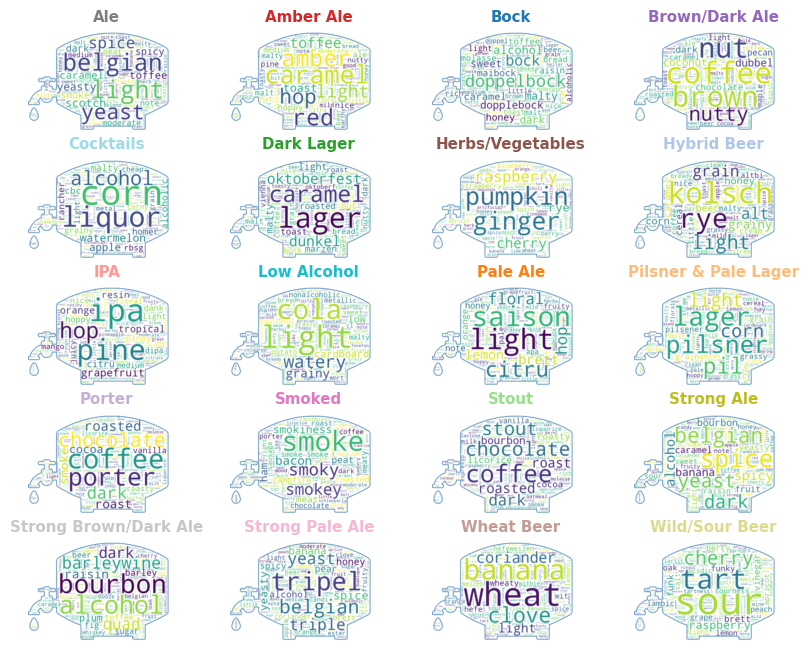

In [43]:
# The mask was download and adapted from https://thenounproject.com/icon/barrel-1028528/
mask = np.array(Image.open('./src/mask.png'))
mask = (mask[:,:,3] > 0).astype('uint8') * 255
mask = util.invert(mask)

# Setting the plots parameters
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(10, 8))
ax = ax.flatten()

# Generate word cloud for each Main_style
for index, row in df_txt_style_grouped.iterrows():
    style = row['macro_style']
    keywords_string = row['keywords']
    
    # Create WordCloud
    wordcloud = WordCloud(background_color='white', mask=mask, contour_color='steelblue', contour_width=3).generate(keywords_string)
    # Plot the WordCloud on the current axis
    ax[index].imshow(wordcloud, interpolation='bilinear')
    title_color = palette_styles.get(style, 'black')
    ax[index].set_title(f'{style}', weight='bold', color=title_color)
    
    ax[index].axis('off')
    
plt.show()

### Prediction of country

The dataset we use for training is the styles_combined dataset created previously:

In [48]:
# Copying dataframe for training the model
training_df = styles_combined.copy()
training_df

,country_brewery,Trimester,1st_Style,2nd_Style,3rd_Style,1st_Score,2nd_Score,3rd_Score
0,Argentina,T1,Smoked,IPA,Stout,-0.001069,-0.240452,-0.368807
1,Argentina,T2,Wild/Sour Beer,IPA,Porter,0.627596,0.015085,-0.387585
2,Argentina,T3,Smoked,Bock,Stout,-0.014951,-0.189497,-0.321432
3,Argentina,T4,Bock,Stout,Strong Pale Ale,0.179469,-0.173703,-0.307675
4,Australia,T1,Strong Brown/Dark Ale,Wild/Sour Beer,IPA,0.437873,0.154562,0.151838
...,...,...,...,...,...,...,...,...
223,United States,T4,Stout,Wild/Sour Beer,Strong Brown/Dark Ale,0.439653,0.417201,0.324176
224,Vietnam,T1,Strong Brown/Dark Ale,Porter,Ale,0.375600,0.244731,-0.005186
225,Vietnam,T2,Wild/Sour Beer,Porter,Stout,0.417331,0.296133,0.200532
226,Vietnam,T3,Strong Brown/Dark Ale,Wild/Sour Beer,Strong Ale,0.548485,-0.048039,-0.056044


As explained in the README, we only have one row per country and season and thus we do not split in train and validation

In [45]:
def train_single_tree(season_df):
    # Features (X)
    features = season_df[['1st_Style', '2nd_Style', '3rd_Style']]

    # Target variable (y)
    target = season_df['country_brewery']


    # Define the columns and transformers for encoding
    categorical_features = ['1st_Style', '2nd_Style', '3rd_Style']

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ])

    # Create the Decision Tree Classifier
    dtc = DecisionTreeClassifier(random_state=27)


    # Create the pipeline
    dtc_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', dtc)])


    # Train the model on the training data
    dtc_model.fit(features, target)

    # Make predictions on the test set
    y_pred = dtc_model.predict(features)

    # Evaluate the accuracy
    accuracy = accuracy_score(target, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    return dtc_model

In [46]:
# Printing accuracy
all_trees = []
for t in training_df.Trimester.unique():
    print('Training for trimester', t)
    season_df = training_df[training_df.Trimester==t]
    tree = train_single_tree(season_df)
    all_trees.append(tree)

Training for trimester T1
Accuracy: 0.9474
Training for trimester T2
Accuracy: 0.9123
Training for trimester T3
Accuracy: 0.8772
Training for trimester T4
Accuracy: 0.9123


We can now visualize one of the trees as an example (the one for the first trimester). Since the variables are one-hot encoded and all decisions are binary, it's hard to clearly visualize the individual decisions, but we can see the whole structure. Nonetheless, meaningful conclusions are hard to extract from this tree, we would ideally have a decision tree with 3 levels where each split is based on choosing between the 20 beer styles.

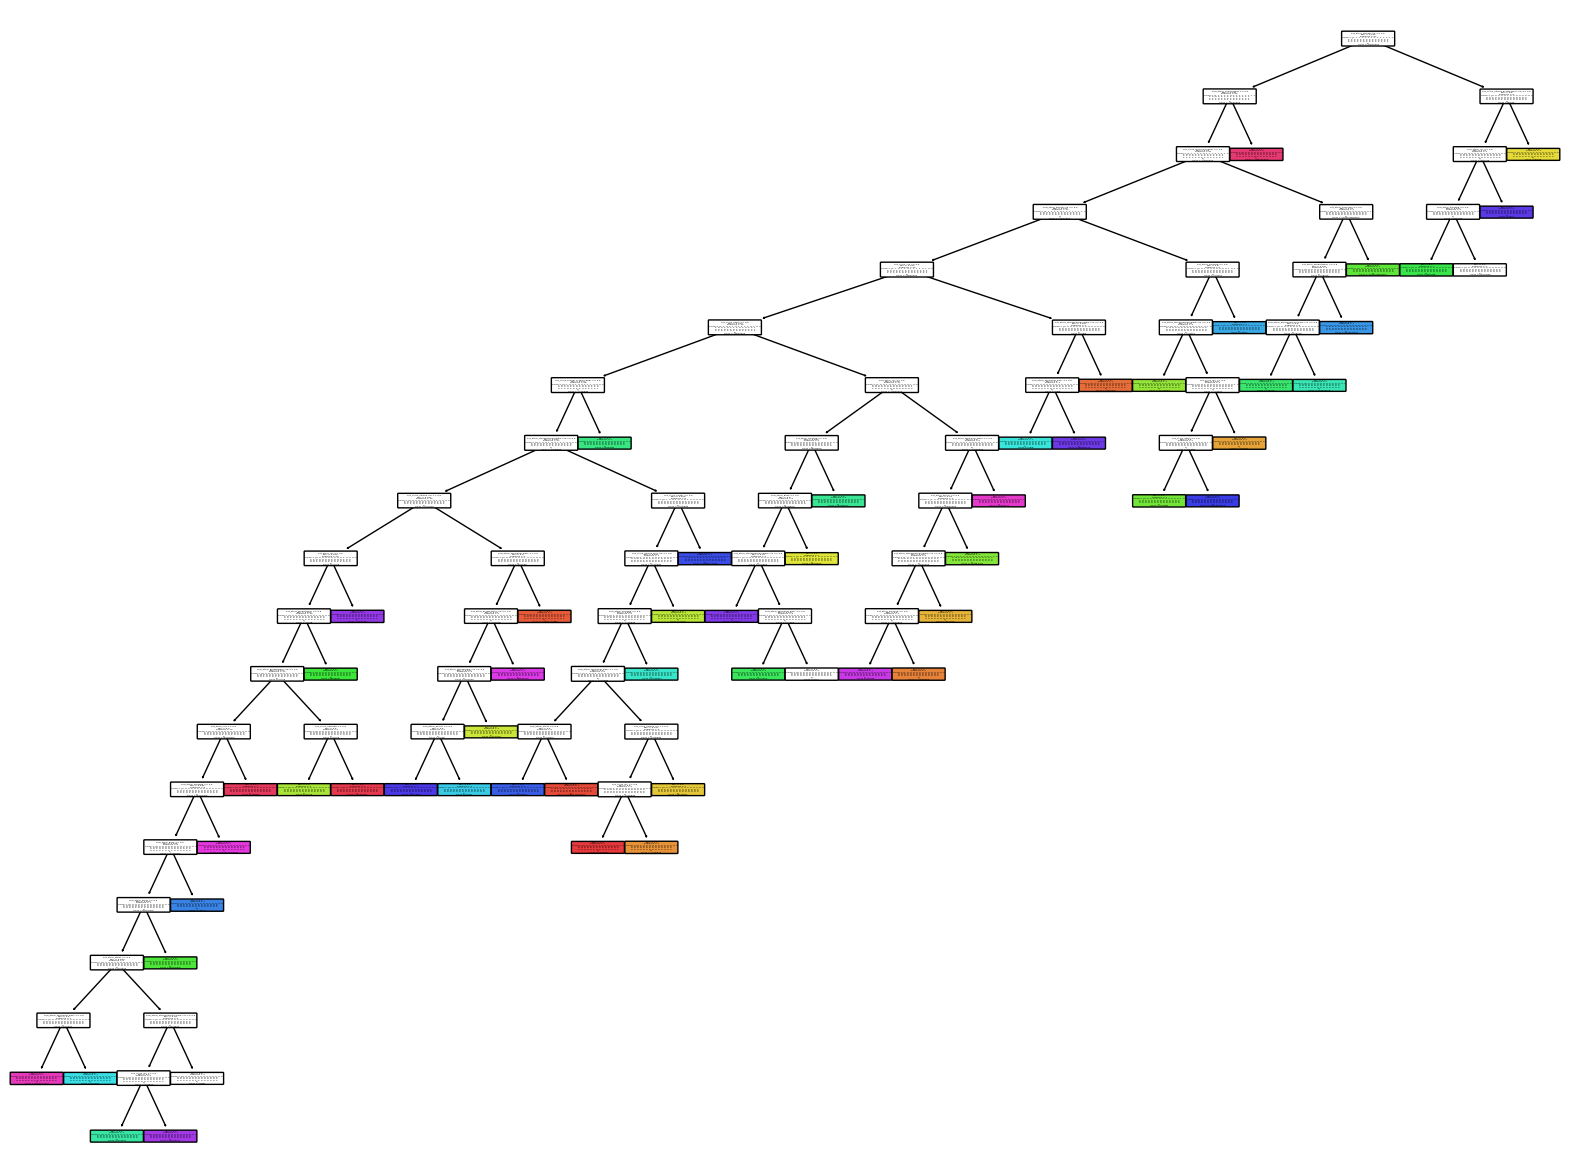

In [47]:
# Get the class names
target = season_df['country_brewery']
categorical_features = ['1st_Style', '2nd_Style', '3rd_Style']
class_names = list(target.unique())
dtc_model = all_trees[0]
# Visualize the Decision Tree
plt.figure(figsize=(20, 15))
plot_tree(dtc_model['classifier'], feature_names=dtc_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features), class_names=class_names, filled=True, rounded=True)
plt.show()